In [279]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [280]:
data = pd.read_csv("data/data.txt")
data = data.sample(frac=1, random_state=12345).reset_index(drop=True)
data['Diabetes'] = data['Diabetes'].map(lambda x: 1 if x=="pos" else 0)
data.head()

,NrPregnant,Glucose,Pressure,Triceps,Insulin,BMI,Pedigree,Age,Diabetes
0,1,95.0,66.0,13.0,38.0,19.6,0.334,25,0
1,0,128.0,68.0,19.0,180.0,30.5,1.391,25,1
2,12,140.0,82.0,43.0,325.0,39.2,0.528,58,1
3,7,195.0,70.0,33.0,145.0,25.1,0.163,55,1
4,8,109.0,76.0,39.0,114.0,27.9,0.640,31,1


#### Managing missing values

In [281]:
print("Proportion of NaNs")
print(data.isna().sum()/data.shape[0])


# Removing rows with nans 
data_cleaned = data.dropna()

Proportion of NaNs
NrPregnant    0.000000
Glucose       0.006510
Pressure      0.045573
Triceps       0.295573
Insulin       0.486979
BMI           0.014323
Pedigree      0.000000
Age           0.000000
Diabetes      0.000000
dtype: float64


In [282]:
print(f"{data_cleaned.shape[0]/data.shape[0]:.3%} of the initial data has been kept")

51.042% of the initial data has been kept


## Classical OLS model (for binomial target data)

In [283]:
import statsmodels.api as sm

X = data_cleaned.drop("Diabetes", axis=1)
Y = data_cleaned["Diabetes"]

model = sm.GLM(Y, sm.add_constant(X, prepend=False), family=sm.families.Binomial())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Diabetes   No. Observations:                  392
Model:                            GLM   Df Residuals:                      383
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -172.01
Date:                Wed, 13 Dec 2023   Deviance:                       344.02
Time:                        18:04:11   Pearson chi2:                     407.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3250
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
NrPregnant     0.0822      0.055      1.482      0.138      -0.026       0.191
Glucose        0.0383      0.006      6.635      0.000       0.027       0.050
Pressure      -0.0014      0.012     -0.120      0.904      -0.025       0.022
Triceps        0.0112      0.017      0.657      0.511      -0.022       0.045
Insulin       -0.0008      0.001     -0.632      0.528      -0.003       0.002
BMI            0.0705      0.027      2.580      0.010       0.017       0.124
Pedigree       1.1409      0.427      2.669      0.008       0.303       1.979
Age            0.0340      0.018      1.847      0.065      -0.002       0.070
const        -10.0407      1.218     -8.246      0.000     -12.427      -7.654
==============================================================================
"""

In [284]:
def TIC(model, results):
    residuals = np.array(results.resid_response)
    n = len(residuals)
    X = model.exog

    K_hat = np.zeros((len(results.params), len(results.params)))
    J_hat = np.zeros((len(results.params), len(results.params)))

    for i in range(n):
        K_hat += residuals[i]**2 * X[i, :].reshape(-1, 1)@X[i, :].reshape(1, -1)
        J_hat += results.mu[i]*(1 - results.mu[i]) * X[i, :].reshape(-1, 1)@X[i, :].reshape(1, -1)

    ll = model.loglike(results.params)
    TIC = -2*ll + 2*np.trace(np.linalg.inv(J_hat)@K_hat)
    return TIC

def AIC(model, results):
    ll = model.loglike(results.params)
    AIC = -2*ll + 2*len(results.params)
    return AIC

print(f"TIC = {TIC(model, results):.4f}")
print(f"AIC = {AIC(model, results):.4f}")

TIC = 365.0225
AIC = 362.0212


## Stepwise method

In [285]:
def print_history(history):
    updates = ["Starting model"]
    for i in range(len(history)-1):
        features, next_features = set(history[i][0]), set(history[i+1][0])
        if len(features) < len(next_features):
            updates.append(f"Added feature {next_features-features}")
        else:
            updates.append(f"Removed feature {features-next_features}")
    for i, (features, score) in enumerate(history):
        print(updates[i])
        print(f"model n°{i} using {len(features)} feature{'s' if len(features)>1 else ''} -> score {score}")
    print(f"The final model uses the following features : {history[-1][0]}")


def stepwise(X, Y, criterion=TIC, mode="forward", verbose=True):
    forward = mode == "forward" or mode == "both"
    backward = mode == "backward" or mode == "both"
    used_features = [] if not backward else list(X.columns)
    if not (forward or backward):
        raise TypeError(f"Unknown mode")
    
    all_features = set(X.columns)
    model = sm.GLM(Y, sm.add_constant(X[used_features], prepend=False), family=sm.families.Binomial())
    results = model.fit()
    score = criterion(model, results)

    history = [(used_features, score)]

    check = True
    while check:
        all_models_scores = {}
        if forward:
            unused_features = list(all_features - set(used_features))
            for feature in unused_features:
                new_feature_set = used_features + [feature]
                new_model = sm.GLM(Y, sm.add_constant(X[new_feature_set], prepend=False), family=sm.families.Binomial())
                new_results = new_model.fit()
                new_score = criterion(new_model, new_results)
                all_models_scores[new_model] = (new_feature_set, new_score)
        
        if backward:
            for feature in used_features:
                new_feature_set = used_features.copy()
                new_feature_set.remove(feature)
                new_model = sm.GLM(Y, sm.add_constant(X[new_feature_set], prepend=False), family=sm.families.Binomial())
                new_results = new_model.fit()
                new_score = criterion(new_model, new_results)
                all_models_scores[new_model] = (new_feature_set, new_score)

        ordered_scores = sorted(all_models_scores.items(), key=lambda x: x[1][1])
        best_model, (best_feature_set, best_score) = ordered_scores[0]
        check = best_score < score
        if check:
            score = best_score
            model = best_model
            used_features = best_feature_set
            history.append((used_features, score))

    if verbose : 
        print_history(history)

    return model, score, used_features

mode = "backward"
criterion = AIC
verbose = True

model, score, used_features = stepwise(X, Y, criterion=criterion, mode=mode, verbose=verbose)


Starting model
model n°0 using 8 features -> score 362.0212318239445
Removed feature {'Pressure'}
model n°1 using 7 features -> score 360.0356212095728
Removed feature {'Insulin'}
model n°2 using 6 features -> score 358.4242027680588
Removed feature {'Triceps'}
model n°3 using 5 features -> score 356.88513185552154
The final model uses the following features : ['NrPregnant', 'Glucose', 'BMI', 'Pedigree', 'Age']


In [286]:
def stepwise_analysis(X, Y):
    for criterion in [AIC, TIC]:
        for mode in ["backward", "forward", "both"]:
            _, score, used_features = stepwise(X, Y, criterion=criterion, mode=mode, verbose=False)
            print(f"Mode : {mode}\tcriterion : {'TIC' if criterion is TIC else 'AIC'}\tscore: {score:.4f}\t features : {', '.join(sorted(used_features))}")

stepwise_analysis(X, Y)

Mode : backward	criterion : AIC	score: 356.8851	 features : Age, BMI, Glucose, NrPregnant, Pedigree


Mode : forward	criterion : AIC	score: 356.8851	 features : Age, BMI, Glucose, NrPregnant, Pedigree
Mode : both	criterion : AIC	score: 356.8851	 features : Age, BMI, Glucose, NrPregnant, Pedigree
Mode : backward	criterion : TIC	score: 358.7826	 features : Age, BMI, Glucose, Pedigree
Mode : forward	criterion : TIC	score: 358.7826	 features : Age, BMI, Glucose, Pedigree
Mode : both	criterion : TIC	score: 358.7826	 features : Age, BMI, Glucose, Pedigree


### LASSO & RIDGE

In [287]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [288]:
# Lasso

l = 1e0 # lambda

lasso_model = LogisticRegression(penalty='l1', C=1/l, solver="liblinear")
lasso_model.fit(X_scaled, Y)
beta_hat_lasso = lasso_model.coef_[0]
print(beta_hat_lasso)

[ 0.2461451   1.12583611  0.          0.11135551 -0.05468926  0.45834307
  0.36831389  0.33254557]


In [289]:
# Ridge

l = 1e0

ridge_model = LogisticRegression(penalty="l2", C=1/l, solver="liblinear")
ridge_model.fit(X_scaled, Y)
beta_hat_ridge = ridge_model.coef_[0]
beta_hat_ridge

array([ 0.25695771,  1.13648127, -0.00929289,  0.12373596, -0.07783104,
        0.47051095,  0.38150537,  0.34006448])

In [290]:
nstep = 100
n_features = X_scaled.shape[1]
elasticnet_l1_ratio = .5

lambdas = np.linspace(1e-5, 100, nstep)

lasso_betas = np.zeros((nstep, n_features))
ridge_betas = np.zeros((nstep, n_features))
elast_betas = np.zeros((nstep, n_features))

for i, l in enumerate(lambdas):
    lasso_model = LogisticRegression(penalty='l1', C=1/l, solver="liblinear")
    lasso_model.fit(X_scaled, Y)
    lasso_betas[i] = lasso_model.coef_[0]

    ridge_model = LogisticRegression(penalty="l2", C=1/l, solver="liblinear")
    ridge_model.fit(X_scaled, Y)
    ridge_betas[i] = ridge_model.coef_[0]

    elast_model = LogisticRegression(penalty="elasticnet", C=1/l, solver="saga", l1_ratio=elasticnet_l1_ratio)
    elast_model.fit(X_scaled, Y)
    elast_betas[i] = elast_model.coef_[0]

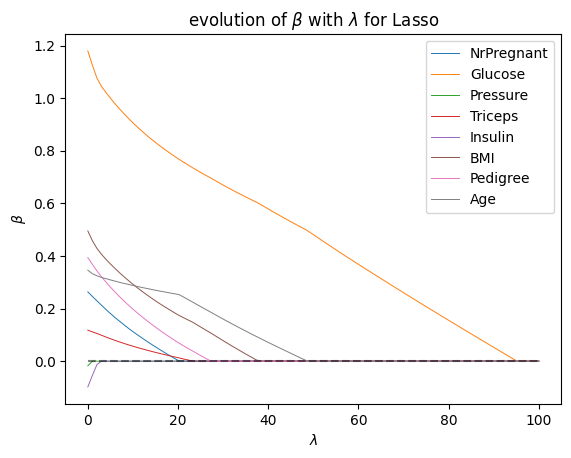

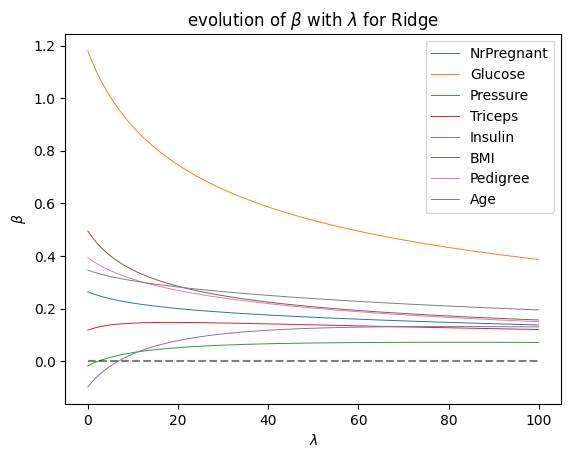

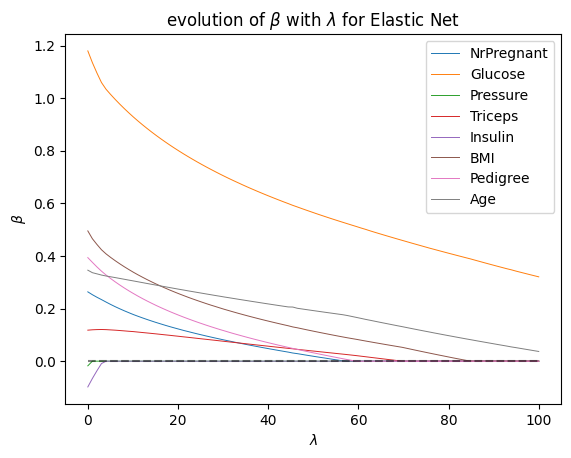

In [291]:
import matplotlib.pyplot as plt

def plot_penalized(X_scaled, Y, model, lambdas, name, legend=True):
    nstep = len(lambdas)
    n_features = X_scaled.shape[1]
    betas = np.zeros((nstep, n_features))
    for i, l in enumerate(lambdas):
        model.C = 1/l
        model.fit(X_scaled, Y)
        betas[i] = model.coef_[0]

    for i, beta in enumerate(betas.T):
        plt.plot(lambdas, beta, label = X_scaled.columns[i], linewidth=0.7)

    plt.ylabel(r"$\beta$")
    plt.xlabel(r"$\lambda$")
    plt.title(r"evolution of $\beta$ with $\lambda$ for {}".format(name))
    plt.plot(lambdas, np.zeros_like(lambdas), linestyle = "--", alpha=0.5, color="black")
    if legend:
        plt.legend()
    plt.savefig(f"ResultsEx1/lambdas_{name.replace(' ', '')}_{X_scaled.shape[0]}_{X_scaled.shape[1]}.png")
    plt.show()

nstep = 100
elasticnet_l1_ratio = .5

lambdas = np.linspace(1e-5, 100, nstep)
lasso_model = LogisticRegression(penalty='l1', solver="liblinear")
ridge_model = LogisticRegression(penalty="l2", solver="liblinear")
elast_model = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=elasticnet_l1_ratio)

plot_penalized(X_scaled, Y, lasso_model, lambdas, "Lasso")
plot_penalized(X_scaled, Y, ridge_model, lambdas, "Ridge")
plot_penalized(X_scaled, Y, elast_model, lambdas, "Elastic Net")

### model selection based on cross_validation

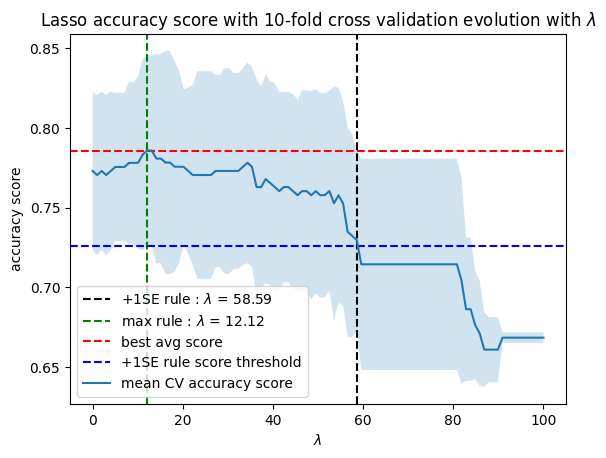

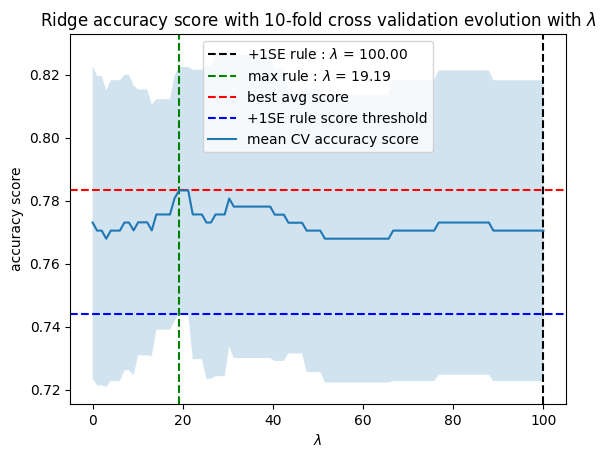

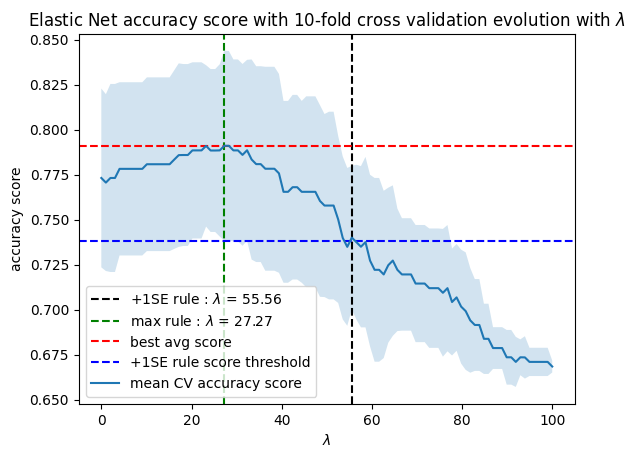

In [292]:
from sklearn.model_selection import cross_val_score

def cross_val_lambda(X_scaled, Y, model, lambdas, n_folds, scoring):
    scores = {}
    for l in lambdas:
        model.C = 1/l
        scores[l] = cross_val_score(model, X_scaled, Y, cv=n_folds, scoring=scoring)
    return scores

def plot_scores(X_scaled, Y, model, lambdas, name, scoring, n_folds):

    scores = cross_val_lambda(X_scaled, Y, model, lambdas, n_folds, scoring)
    scores_mean = np.array([np.mean(scores[l]) for l in scores])
    scores_std = np.array([np.std(scores[l]) for l in scores])
    
    threshold = np.max(scores_mean) - scores_std[np.argmax(scores_mean)]
    best_lambda_1SE = lambdas[scores_mean > threshold][-1]
    best_lambda_max = lambdas[np.argmax(scores_mean)]

    plt.axvline(best_lambda_1SE, linestyle="--", color="black", label=r"+1SE rule : $\lambda$ = {:.2f}".format(best_lambda_1SE))
    plt.axvline(best_lambda_max, linestyle="--", color="green", label=r"max rule : $\lambda$ = {:.2f}".format(best_lambda_max))
    plt.axhline(np.max(scores_mean), linestyle="--", color="red", label="best avg score")
    plt.axhline(threshold, linestyle="--", color="blue", label="+1SE rule score threshold")
    plt.plot(lambdas, scores_mean, label="mean CV {} score".format(scoring))
    plt.fill_between(lambdas, scores_mean-scores_std, scores_mean+scores_std, alpha=0.2)
    plt.xlabel(r"$\lambda$")
    plt.ylabel(f"{scoring} score")
    plt.legend()
    plt.title(r"{} {} score with {}-fold cross validation evolution with $\lambda$".format(name, scoring, n_folds))
    plt.savefig(f"ResultsEx1/Error_{name.replace(' ', '')}_{X_scaled.shape[0]}_{X_scaled.shape[1]}.png")
    plt.show()

    return best_lambda_1SE, best_lambda_max

n_folds = 10
nstep = 100
n_features = X_scaled.shape[1]
elasticnet_l1_ratio = .5
scoring = "accuracy"
lambdas = np.linspace(1e-5, 100, nstep)

lasso_model = LogisticRegression(penalty="l1", solver="liblinear")
lasso_1SE_lambda, lasso_max_lambda = plot_scores(X_scaled, Y, lasso_model, lambdas, "Lasso", scoring, n_folds)

ridge_model = LogisticRegression(penalty="l2", solver="liblinear")
ridge_1SE_lambda, ridge_max_lambda = plot_scores(X_scaled, Y, ridge_model, lambdas, "Ridge", scoring, n_folds)

elast_model = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=elasticnet_l1_ratio)
elast_1SE_lambda, elast_max_lambda = plot_scores(X_scaled, Y, elast_model, lambdas, "Elastic Net", scoring, n_folds)

In [293]:
lasso_max_model = LogisticRegression(penalty='l1', C=1/lasso_max_lambda, solver="liblinear")
lasso_1SE_model = LogisticRegression(penalty='l1', C=1/lasso_1SE_lambda, solver="liblinear")
elast_max_model = LogisticRegression(penalty="elasticnet", C=1/elast_max_lambda, solver="saga", l1_ratio=elasticnet_l1_ratio)
elast_1SE_model = LogisticRegression(penalty="elasticnet", C=1/elast_1SE_lambda, solver="saga", l1_ratio=elasticnet_l1_ratio)

models = [lasso_max_model, lasso_1SE_model, elast_max_model, elast_1SE_model]
for model in models:
    model.fit(X_scaled, Y)

print(f"Lasso model with max rule \t: {', '.join(X_scaled.columns[lasso_max_model.coef_[0] != 0])}")
print(f"Lasso model with +1SE rule \t: {', '.join(X_scaled.columns[lasso_1SE_model.coef_[0] != 0])}")
print(f"Elasticnet model with max rule \t: {', '.join(X_scaled.columns[elast_max_model.coef_[0] != 0])}")
print(f"Elasticnet model with +1SE rule\t: {', '.join(X_scaled.columns[elast_1SE_model.coef_[0] != 0])}")

Lasso model with max rule 	: NrPregnant, Glucose, Triceps, BMI, Pedigree, Age
Lasso model with +1SE rule 	: Glucose
Elasticnet model with max rule 	: NrPregnant, Glucose, Triceps, BMI, Pedigree, Age
Elasticnet model with +1SE rule	: NrPregnant, Glucose, Triceps, BMI, Pedigree, Age


### Adding data interactions

In [294]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X2 = poly.fit_transform(X)
X2 = pd.DataFrame(X2, columns=poly.get_feature_names_out())

Y2 = Y.reset_index(drop=True)

X2.head()

,NrPregnant,Glucose,Pressure,Triceps,Insulin,BMI,Pedigree,Age,NrPregnant^2,NrPregnant Glucose,...,Insulin^2,Insulin BMI,Insulin Pedigree,Insulin Age,BMI^2,BMI Pedigree,BMI Age,Pedigree^2,Pedigree Age,Age^2
0,1.0,95.0,66.0,13.0,38.0,19.6,0.334,25.0,1.0,95.0,...,1444.0,744.8,12.692,950.0,384.16,6.5464,490.0,0.111556,8.350,625.0
1,0.0,128.0,68.0,19.0,180.0,30.5,1.391,25.0,0.0,0.0,...,32400.0,5490.0,250.380,4500.0,930.25,42.4255,762.5,1.934881,34.775,625.0
2,12.0,140.0,82.0,43.0,325.0,39.2,0.528,58.0,144.0,1680.0,...,105625.0,12740.0,171.600,18850.0,1536.64,20.6976,2273.6,0.278784,30.624,3364.0
3,7.0,195.0,70.0,33.0,145.0,25.1,0.163,55.0,49.0,1365.0,...,21025.0,3639.5,23.635,7975.0,630.01,4.0913,1380.5,0.026569,8.965,3025.0
4,8.0,109.0,76.0,39.0,114.0,27.9,0.640,31.0,64.0,872.0,...,12996.0,3180.6,72.960,3534.0,778.41,17.8560,864.9,0.409600,19.840,961.0


In [295]:
# stepwise_analysis(X2, Y2)

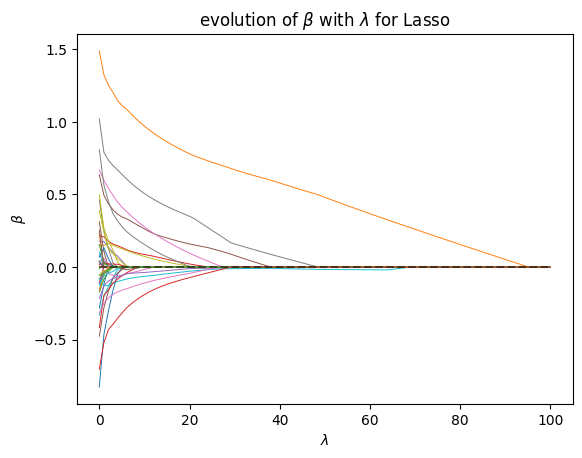

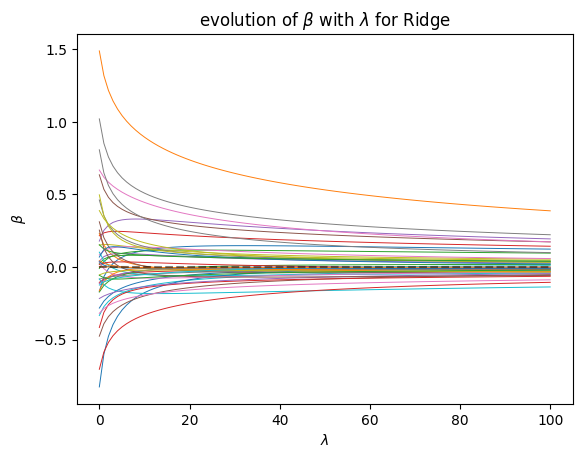

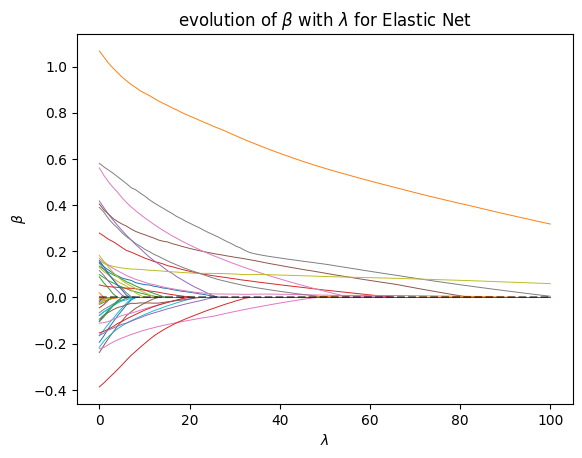

In [296]:
X2_scaled = poly.fit_transform(X_scaled)
X2_scaled = pd.DataFrame(X2_scaled, columns=poly.get_feature_names_out())

nstep = 100
elasticnet_l1_ratio = .5

lambdas = np.linspace(1e-5, 100, nstep)
lasso_model = LogisticRegression(penalty='l1', solver="liblinear")
ridge_model = LogisticRegression(penalty="l2", solver="liblinear")
elast_model = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=elasticnet_l1_ratio)

plot_penalized(X2_scaled, Y2, lasso_model, lambdas, "Lasso", legend=False)
plot_penalized(X2_scaled, Y2, ridge_model, lambdas, "Ridge", legend=False)
plot_penalized(X2_scaled, Y2, elast_model, lambdas, "Elastic Net", legend=False)

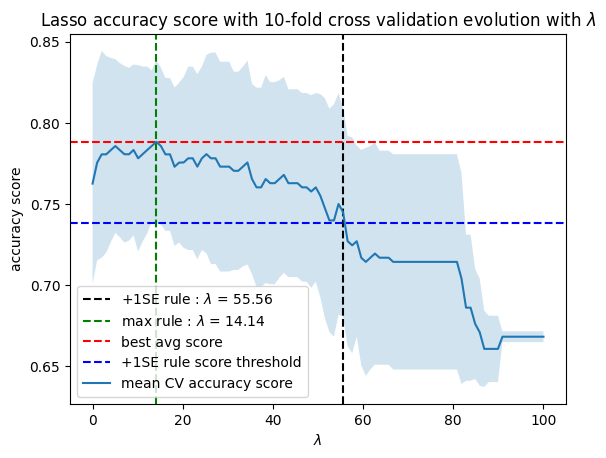

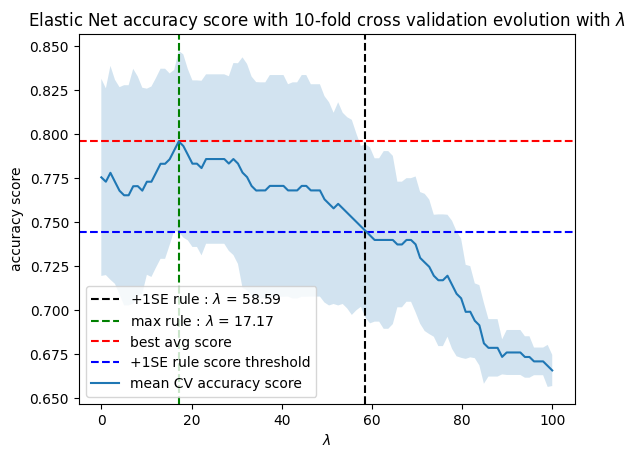

In [297]:
n_folds = 10
nstep = 100
n_features = X_scaled.shape[1]
elasticnet_l1_ratio = .5
scoring = "accuracy"
lambdas = np.linspace(1e-5, 100, nstep)

lasso_model = LogisticRegression(penalty="l1", solver="liblinear")
lasso_1SE_lambda, lasso_max_lambda = plot_scores(X2_scaled, Y2, lasso_model, lambdas, "Lasso", scoring, n_folds)

elast_model = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=elasticnet_l1_ratio)
elast_1SE_lambda, elast_max_lambda = plot_scores(X2_scaled, Y2, elast_model, lambdas, "Elastic Net", scoring, n_folds)

In [298]:
lasso_max_model = LogisticRegression(penalty='l1', C=1/lasso_max_lambda, solver="liblinear")
lasso_1SE_model = LogisticRegression(penalty='l1', C=1/lasso_1SE_lambda, solver="liblinear")
elast_max_model = LogisticRegression(penalty="elasticnet", C=1/elast_max_lambda, solver="saga", l1_ratio=elasticnet_l1_ratio)
elast_1SE_model = LogisticRegression(penalty="elasticnet", C=1/elast_1SE_lambda, solver="saga", l1_ratio=elasticnet_l1_ratio)

models = [lasso_max_model, lasso_1SE_model, elast_max_model, elast_1SE_model]
for model in models:
    model.fit(X2_scaled, Y2)

print(f"Lasso model with max rule \t: {', '.join(X2_scaled.columns[lasso_max_model.coef_[0] != 0])}")
print(f"Lasso model with +1SE rule \t: {', '.join(X2_scaled.columns[lasso_1SE_model.coef_[0] != 0])}")
print(f"Elasticnet model with max rule \t: {', '.join(X2_scaled.columns[elast_max_model.coef_[0] != 0])}")
print(f"Elasticnet model with +1SE rule\t: {', '.join(X2_scaled.columns[elast_1SE_model.coef_[0] != 0])}")

Lasso model with max rule 	: Glucose, Triceps, BMI, Pedigree, Age, NrPregnant^2, Triceps^2, Insulin^2, Insulin Pedigree, Insulin Age, Age^2
Lasso model with +1SE rule 	: Glucose, Triceps^2
Elasticnet model with max rule 	: NrPregnant, Glucose, Triceps, Insulin, BMI, Pedigree, Age, NrPregnant^2, Glucose^2, Pressure^2, Pressure BMI, Triceps^2, Triceps Age, Insulin^2, Insulin BMI, Insulin Pedigree, Insulin Age, Age^2
Elasticnet model with +1SE rule	: Glucose, Triceps, BMI, Age, NrPregnant^2, Glucose^2, Pedigree^2


### As every method tested so far were concluding on the fact that the "Insulin" and "Pressure" features were not significant, we remove these from the original data to have less Missing values and thus more samples for the last analysis.

In [299]:
unused_features = ["Insulin", "Pressure"]
data_filtered = data.drop(unused_features, axis=1)
data_filtered_cleaned = data_filtered.dropna()

print(f"{data_filtered_cleaned.shape[0]/data.shape[0]:.3%} of the initial data has been kept")

X3 = data_filtered_cleaned.drop("Diabetes", axis=1)
X3_scaled = pd.DataFrame(scaler.fit_transform(X3), columns=X3.columns)
Y3 = data_filtered_cleaned["Diabetes"]

69.531% of the initial data has been kept


In [300]:
stepwise_analysis(X3, Y3)

Mode : backward	criterion : AIC	score: 479.6520	 features : Age, BMI, Glucose, NrPregnant, Pedigree
Mode : forward	criterion : AIC	score: 479.6520	 features : Age, BMI, Glucose, NrPregnant, Pedigree
Mode : both	criterion : AIC	score: 479.6520	 features : Age, BMI, Glucose, NrPregnant, Pedigree
Mode : backward	criterion : TIC	score: 480.8933	 features : Age, BMI, Glucose, NrPregnant, Pedigree
Mode : forward	criterion : TIC	score: 480.8933	 features : Age, BMI, Glucose, NrPregnant, Pedigree
Mode : both	criterion : TIC	score: 480.8933	 features : Age, BMI, Glucose, NrPregnant, Pedigree


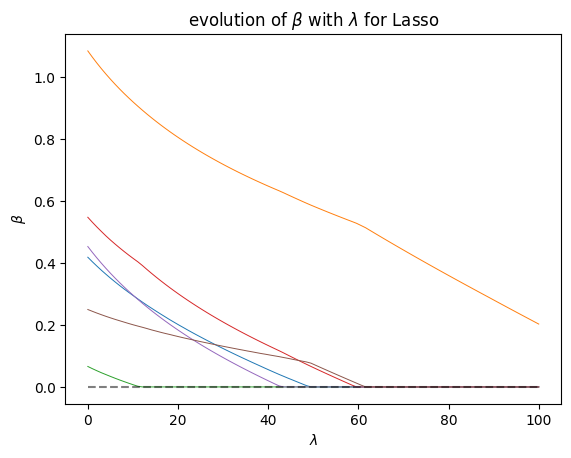

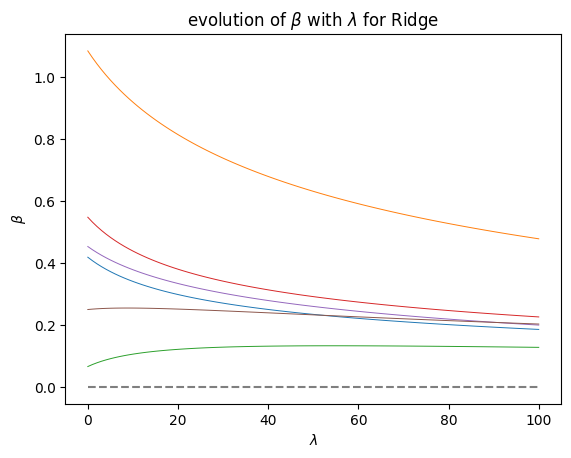

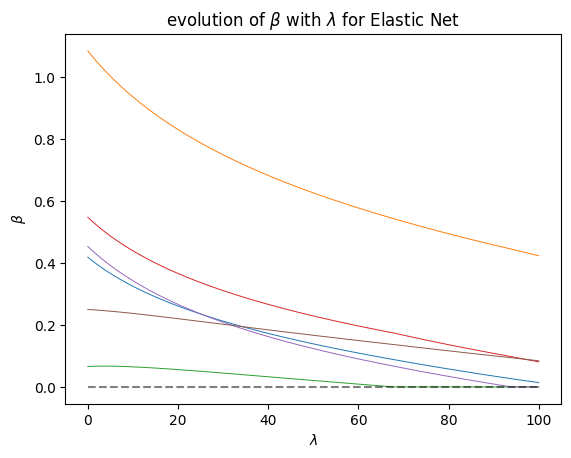

In [301]:
nstep = 100
elasticnet_l1_ratio = .5

lambdas = np.linspace(1e-5, 100, nstep)
lasso_model = LogisticRegression(penalty='l1', solver="liblinear")
ridge_model = LogisticRegression(penalty="l2", solver="liblinear")
elast_model = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=elasticnet_l1_ratio)

plot_penalized(X3_scaled, Y3, lasso_model, lambdas, "Lasso", legend=False)
plot_penalized(X3_scaled, Y3, ridge_model, lambdas, "Ridge", legend=False)
plot_penalized(X3_scaled, Y3, elast_model, lambdas, "Elastic Net", legend=False)

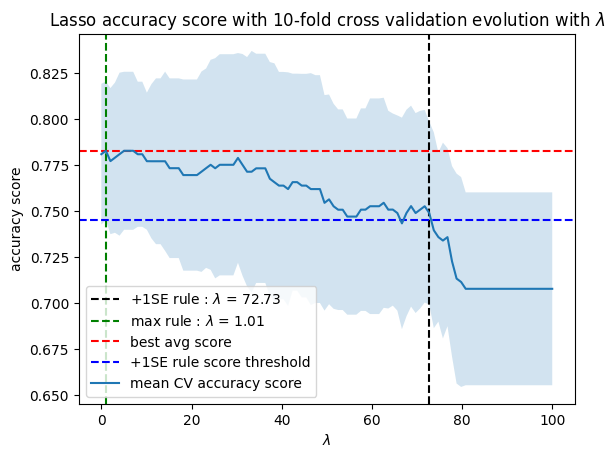

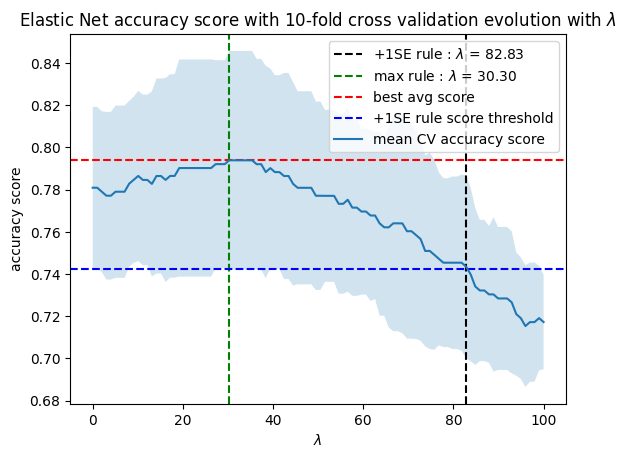

In [302]:
n_folds = 10
nstep = 100
n_features = X_scaled.shape[1]
elasticnet_l1_ratio = .5
scoring = "accuracy"
lambdas = np.linspace(1e-5, 100, nstep)

lasso_model = LogisticRegression(penalty="l1", solver="liblinear")
lasso_1SE_lambda, lasso_max_lambda = plot_scores(X3_scaled, Y3, lasso_model, lambdas, "Lasso", scoring, n_folds)

elast_model = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=elasticnet_l1_ratio)
elast_1SE_lambda, elast_max_lambda = plot_scores(X3_scaled, Y3, elast_model, lambdas, "Elastic Net", scoring, n_folds)

In [303]:
lasso_max_model = LogisticRegression(penalty='l1', C=1/lasso_max_lambda, solver="liblinear")
lasso_1SE_model = LogisticRegression(penalty='l1', C=1/lasso_1SE_lambda, solver="liblinear")
elast_max_model = LogisticRegression(penalty="elasticnet", C=1/elast_max_lambda, solver="saga", l1_ratio=elasticnet_l1_ratio)
elast_1SE_model = LogisticRegression(penalty="elasticnet", C=1/elast_1SE_lambda, solver="saga", l1_ratio=elasticnet_l1_ratio)

models = [lasso_max_model, lasso_1SE_model, elast_max_model, elast_1SE_model]
for model in models:
    model.fit(X3_scaled, Y3)

print(f"Lasso model with max rule \t: {', '.join(X3_scaled.columns[lasso_max_model.coef_[0] != 0])}")
print(f"Lasso model with +1SE rule \t: {', '.join(X3_scaled.columns[lasso_1SE_model.coef_[0] != 0])}")
print(f"Elasticnet model with max rule \t: {', '.join(X3_scaled.columns[elast_max_model.coef_[0] != 0])}")
print(f"Elasticnet model with +1SE rule\t: {', '.join(X3_scaled.columns[elast_1SE_model.coef_[0] != 0])}")


Lasso model with max rule 	: NrPregnant, Glucose, Triceps, BMI, Pedigree, Age
Lasso model with +1SE rule 	: Glucose
Elasticnet model with max rule 	: NrPregnant, Glucose, Triceps, BMI, Pedigree, Age
Elasticnet model with +1SE rule	: NrPregnant, Glucose, BMI, Pedigree, Age


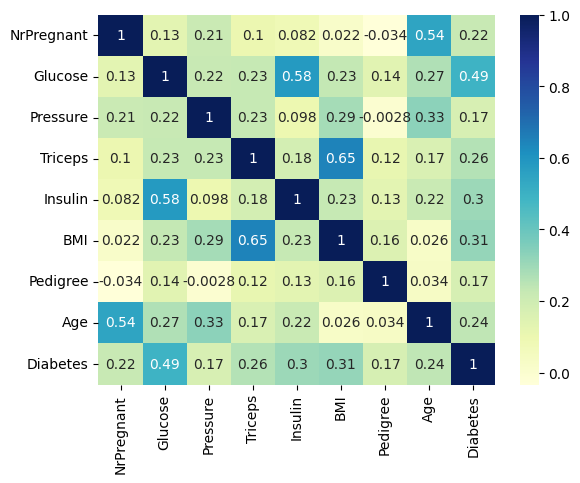

In [304]:
# plot the correlation matrix of the data
import seaborn as sns
corr = data.corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.show()